<a href="https://colab.research.google.com/github/PhilipPfeffer/haptic_vest/blob/main/mobilenet_retrain_balanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrained MobileNet
MobileNet has been trained for many applications, including image segmentation, bounding box detection and ImageNet classification. In this notebook, we retrain the smallest version of MobileNet to classify whether an image in our dataset contains a 'person', a 'car' or 'neither.

# Acknowledgements
This was inspired by https://www.tensorflow.org/tutorials/images/transfer_learning (Accessed 29 Oct 2020).

# Dataset

## Imports
General Setup; GPU setup is under Training.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import zipfile
import shutil
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

## Fetch Data (OLD)
Upload the zip file of our images into '/content/' (i.e. the root of the Colab file directory. Then fetch the data using the code below.

`dataset_X` refers to the dataset you want to use, where `X` is the desired maximum images per category.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Definitions
# dataset ='/content/drive/My Drive/Haptic Vest/dataset_person_car'
# classes = ['neither', 'person', None , 'car']
# class_ids = [0,1,3]
# dataset_types = ['train','dev','test']
# all_processed_imgs_dir = '/content/drive/My Drive/Haptic Vest/person_car_other_imgs_processed'

# train_ids = np.loadtxt(dataset, dtype=(int, int))
# train_ids_dict = dict(train_ids)

# x_train_ids, y_train_ids = train_ids[:,0], train_ids[:,1]
# assert(x_train_ids.shape == y_train_ids.shape)
# x_train_ids[0], y_train_ids[0]
# print(f"There are {len(x_train_ids)} images, set(x_train_ids) = {len(set(x_train_ids))} images.")

In [4]:
# ######################### 
# # CHANGE HERE
# ######################### 
# dataset_extension = '40000'
# ######################### 

# zip_file_path = '/content/processed_subset' + dataset_extension + '.zip'
# unzipped_dir = '/content/'
# dataset_X = unzipped_dir + 'processed_subset' + dataset_extension
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(unzipped_dir)

Create sub-folder structure for Tensorflow to load from directory

In [5]:
# # In case of problem, pull emergency switch
# for dataset_type in dataset_types:
#   shutil.rmtree(dataset_X + '/' + dataset_type, ignore_errors=True)

# leaf_folders = [list(zip([dataset_types[i]]*3, class_ids)) for i in range(len(dataset_types))]
# leaf_folders = [list(zip([dataset_types[i]]*3, class_ids)) for i in range(len(dataset_types))]
# subpaths = [dataset_X + '/' + folder[0] + '/' + str(folder[1]) for folder_list in leaf_folders for folder in folder_list ]
# for subpath in subpaths:
#   os.makedirs(subpath, mode=0o777, exist_ok=False)

## Dataset Creation (OLD)
These two cells are taken from Phil Pfeffer's implenetation of customnn.ipynb, part of his concurrent CS229 project.

In [6]:
# dataset_X_ids = {}
# dataset_X_labels = []
# for entry in os.scandir(dataset_X):
#   if entry.is_dir() or os.path.basename(entry)[0] == '.':
#     continue
#   id = int(os.path.basename(entry)[:-4])
#   dataset_X_ids[id] = train_ids_dict[id]
#   dataset_X_labels.append(train_ids_dict[id])

# print(len(dataset_X_ids))
# print(len(dataset_X_labels))

# dev_pct = 0.1
# test_pct = 0.05
# train_pct = 1 - dev_pct - test_pct
# assert (dev_pct + test_pct + train_pct == 1)

# num_neither = np.sum(np.array(dataset_X_labels)==0)
# num_person = np.sum(np.array(dataset_X_labels)==1)
# num_car = np.sum(np.array(dataset_X_labels)==3)
# num_class_examples = {0:num_neither, 1:num_person, 3: num_car}
# print(num_class_examples, num_neither +num_person + num_car)


# num_test = {key: int(test_pct * num_class) for key, num_class in num_class_examples.items()}
# num_dev = {key: int(dev_pct * num_class) for key, num_class in num_class_examples.items()}
# num_train = {class_id: num_class_examples[class_id] - num_dev[class_id] - num_test[class_id] for class_id in class_ids}

# print(num_test, "\n", num_dev, "\n", num_train)

In [7]:
# def path_to_id(path):
#   return int(os.path.basename(entry)[:-4])

# num_test_done = {class_id: 0 for class_id in class_ids}
# num_dev_done = {class_id: 0 for class_id in class_ids}
# num_train_done = {class_id: 0 for class_id in class_ids}
# for idx, entry in enumerate(os.scandir(dataset_X)):
#   if entry.is_dir() or os.path.basename(entry)[0] == '.':
#     continue
#   id = path_to_id(entry)
#   label = train_ids_dict[id]
  
#   if num_train_done[label] != num_train[label]:
#     num_train_done[label] += 1
#     shutil.copyfile(entry, dataset_X + '/train/' + str(label) + '/' + os.path.basename(entry))
#   elif num_dev_done[label] != num_dev[label]:
#     num_dev_done[label] += 1
#     shutil.copyfile(entry, dataset_X + '/dev/' + str(label) + '/' + os.path.basename(entry))
#   elif num_test_done[label] != num_test[label]:
#     num_test_done[label] += 1
#     shutil.copyfile(entry, dataset_X + '/test/' + str(label) + '/' + os.path.basename(entry))
  
#   if idx % 5000 == 0:
#     print(idx, num_train_done, num_dev_done, num_test_done)

# print(num_train_done, num_dev_done, num_test_done)

## Unzip Dataset

In [9]:
dataset_name = 'dataset_balanced'
zip_file_path = '/content/' + dataset_name + '.zip'
unzipped_dir = '/content'
dataset_X = '/content/' + dataset_name
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzipped_dir)

## Create Dataloader

In [10]:
BATCH_SIZE = 32
ORIG_IMG_SIZE = (96, 96)
ORIG_COLOR_MODE ='grayscale'
IMG_SIZE = (128,128)
COLOR_MODE = 'rgb'

train_dataset = image_dataset_from_directory(dataset_X +'/train/', label_mode='categorical', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)
dev_dataset = image_dataset_from_directory(dataset_X +'/dev/', label_mode='categorical', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)
test_dataset = image_dataset_from_directory(dataset_X +'/test/', label_mode='categorical', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)

Found 70662 files belonging to 3 classes.
Found 7105 files belonging to 3 classes.
Found 3952 files belonging to 3 classes.


(128, 128, 3)


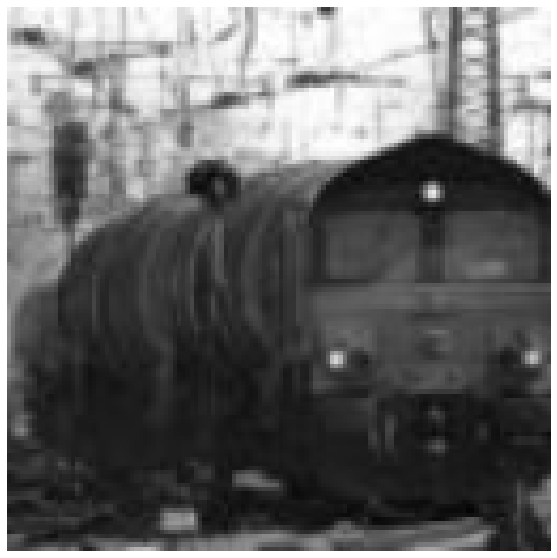

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  # for i in range(9):
  #   ax = plt.subplot(3, 3, i + 1)
    # augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    # plt.imshow(augmented_image[0] / 255)
  plt.imshow(first_image / 255)
  plt.axis('off')
  print(first_image.shape)
  break

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
dev_dataset = dev_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation
Add data augmentation to all images

In [13]:
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#   tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
# ])

# # convert to 3 channel (RGB)
# x = np.stack((x,)*3, axis=-1) 

# MobileNet Model

In [14]:
preprocess_input = tf.keras.applications.mobilenet.preprocess_input

In [15]:
# TODO: Replace this base_model line so that it loads one of the 0.5MB models from 
# https://www.tensorflow.org/lite/guide/hosted_models#image_classification
# instead of whatever this default model is

# Create the base model from the pre-trained model MobileNet
IMG_SHAPE = IMG_SIZE + (3,)

#Same syntax for MobileNetV2 and V1
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                               alpha=0.25, # just add this
                                               include_top=False,
                                               weights='imagenet')

2113536/2108140 [==============================] - 0s 0us/step


In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 4, 4, 256)


## GPU Setup

In [17]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [18]:
base_model.trainable = False
base_model.summary()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

Model: "mobilenet_0.25_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 8)         216       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 8)         32        
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 8)         0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 8)         72        
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 8)  

In [19]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
base_learning_rate = 0.0001
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), metrics=['accuracy'])

# model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
#               loss=tf.keras.losses.CategoricalCrossentropy(),
#               metrics=['accuracy'])

In [21]:
model.summary()
len(model.trainable_variables)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenet_0.25_128 (Function (None, 4, 4, 256)         218544    
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                

2

## Training

In [22]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(dev_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

223/223 [==============================] - 4s 20ms/step - loss: 2.2364 - accuracy: 0.2431
initial loss: 2.24
initial accuracy: 0.24


In [23]:
with tf.device('/device:GPU:0'):
  history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=dev_dataset)

Epoch 1/10
2209/2209 [==============================] - 56s 25ms/step - loss: 0.8590 - accuracy: 0.6550 - val_loss: 0.8207 - val_accuracy: 0.7019
Epoch 2/10
2209/2209 [==============================] - 61s 28ms/step - loss: 0.4867 - accuracy: 0.8033 - val_loss: 0.7919 - val_accuracy: 0.7232
Epoch 3/10
2209/2209 [==============================] - 59s 27ms/step - loss: 0.4342 - accuracy: 0.8246 - val_loss: 0.7647 - val_accuracy: 0.7348
Epoch 4/10
2209/2209 [==============================] - 58s 26ms/step - loss: 0.4163 - accuracy: 0.8296 - val_loss: 0.7421 - val_accuracy: 0.7424
Epoch 5/10
2209/2209 [==============================] - 58s 26ms/step - loss: 0.4047 - accuracy: 0.8347 - val_loss: 0.7283 - val_accuracy: 0.7426
Epoch 6/10
2209/2209 [==============================] - 58s 26ms/step - loss: 0.4013 - accuracy: 0.8361 - val_loss: 0.7272 - val_accuracy: 0.7447
Epoch 7/10
2209/2209 [==============================] - 57s 26ms/step - loss: 0.3953 - accuracy: 0.8385 - val_loss: 0.7232 -

## Learning Plot

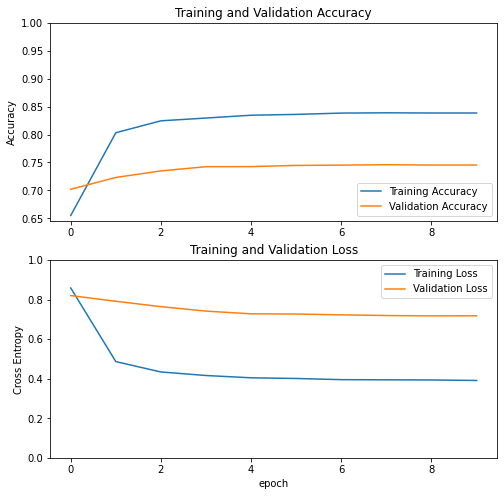

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

From GOOGLE
Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Unfreeze the model

In [25]:
base_model.trainable = True

In [26]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  87


In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenet_0.25_128 (Function (None, 4, 4, 256)         218544    
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                

In [28]:
len(model.trainable_variables)

2

### Continue training the model

In [29]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=dev_dataset)

Epoch 10/20
2209/2209 [==============================] - 53s 24ms/step - loss: 0.3915 - accuracy: 0.8392 - val_loss: 0.7265 - val_accuracy: 0.7444
Epoch 11/20
2209/2209 [==============================] - 56s 25ms/step - loss: 0.3917 - accuracy: 0.8382 - val_loss: 0.7266 - val_accuracy: 0.7447
Epoch 12/20
2209/2209 [==============================] - 57s 26ms/step - loss: 0.3906 - accuracy: 0.8397 - val_loss: 0.7282 - val_accuracy: 0.7448
Epoch 13/20
2209/2209 [==============================] - 57s 26ms/step - loss: 0.3909 - accuracy: 0.8406 - val_loss: 0.7309 - val_accuracy: 0.7447
Epoch 14/20
2209/2209 [==============================] - 56s 25ms/step - loss: 0.3902 - accuracy: 0.8400 - val_loss: 0.7294 - val_accuracy: 0.7451
Epoch 15/20
2209/2209 [==============================] - 57s 26ms/step - loss: 0.3919 - accuracy: 0.8405 - val_loss: 0.7308 - val_accuracy: 0.7457
Epoch 16/20
2209/2209 [==============================] - 57s 26ms/step - loss: 0.3908 - accuracy: 0.8399 - val_loss: 0

In [30]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

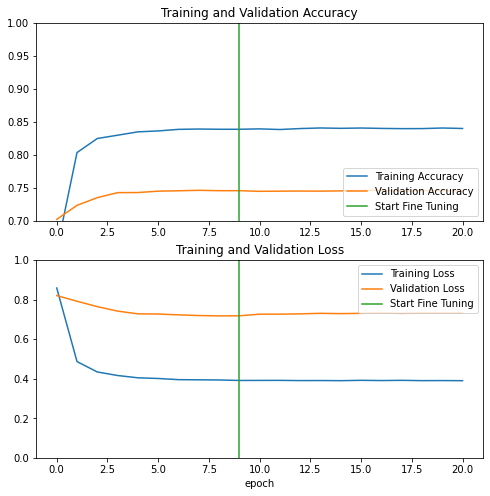

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.7, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

In [33]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

124/124 [==============================] - 3s 22ms/step - loss: 0.9459 - accuracy: 0.6926
Test accuracy : 0.6925607323646545


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


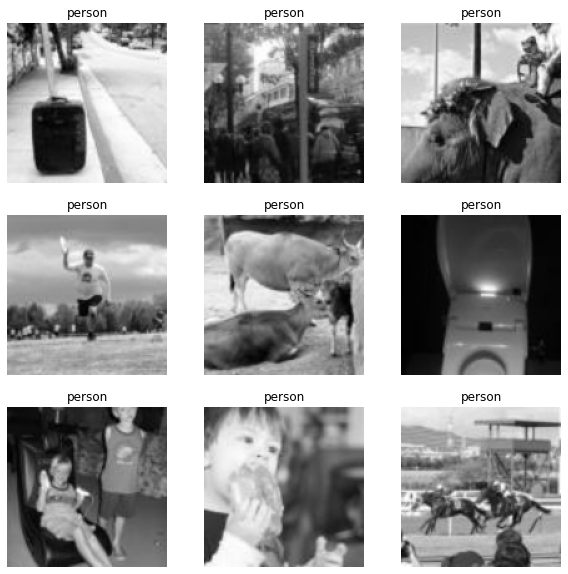

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(classes[predictions[i]])
  plt.axis("off")

# Convert the model to tflite

In [ ]:
# Convert
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpwgyqidrd/assets


# Build for Raspberry Pi

#### Reference: https://www.tensorflow.org/lite/guide/build_rpi